In [1]:
%matplotlib inline
import numpy as np
np.random.seed(123)

import random as rn
rn.seed(231)

import tensorflow as tf
tf.random.set_seed(321)

import pandas as pd
from tensorflow.keras import layers
import seaborn as sns
import epitopepredict as ep
from keras import *
from keras.utils import to_categorical
from sklearn.preprocessing import OneHotEncoder
from sklearn.model_selection import train_test_split
import matplotlib.pyplot as plt

from sklearn.ensemble import RandomForestClassifier
from sklearn.metrics import classification_report, confusion_matrix

import os
import platform
print("Python Version: ", platform.python_version())
print(os.getcwd())

Using TensorFlow backend.


Python Version:  3.7.4
/Users/matthewbuckley/Dropbox/TCR.Learning/notebooks


In [2]:
# Load data
data = pd.read_csv('../R/data/PairedTCR_HLA-A*02.01_VDJdb.tsv', delimiter="\t" )
print(data.shape)

(3555, 11)


In [3]:
data = data.groupby("antigen.epitope").filter(lambda x: len(x) > 50)
print(data["antigen.epitope"].value_counts())

GILGFVFTL     2044
ELAGIGILTV     329
GLCTLVAML      302
LLWNGPMAV      247
NLVPMVATV      198
CINGVCWTV       79
Name: antigen.epitope, dtype: int64


In [4]:
# Naive Accuracy
max(data["antigen.epitope"].value_counts()) / sum(data["antigen.epitope"].value_counts())

0.6389496717724289

In [5]:
# Largest cdr3.beta sequence?
sizes = [len(i) for i in data["cdr3.beta"]]
max(sizes)

21

In [6]:
# Largest cdr3.beta sequence?
sizes = [len(i) for i in data["cdr3.alpha"]]
max(sizes)

24

In [7]:
# Padding
data["cdr3_b_pad"] = data["cdr3.beta"].str.ljust(22, "0")
data["cdr3_a_pad"] = data["cdr3.alpha"].str.ljust(25, "0")
data.head()

,cdr3.alpha,v.alpha,j.alpha,cdr3.beta,v.beta,d.beta,j.beta,mhc.a,mhc.b,reference.id,antigen.epitope,cdr3_b_pad,cdr3_a_pad
0,CAGNNARPMF,TRAV27*01,TRAJ31*01,CASSQSPGGVAFF,TRBV14*01,NaN,TRBJ1-1*01,HLA-A*02:01,B2M,PMID:11046006,GLCTLVAML,CASSQSPGGVAFF000000000,CAGNNARPMF000000000000000
1,CAGNNARLMF,TRAV27*01,TRAJ31*01,CASSQSPGGVAFF,TRBV14*01,NaN,TRBJ1-1*01,HLA-A*02:01,B2M,PMID:11046006,GLCTLVAML,CASSQSPGGVAFF000000000,CAGNNARLMF000000000000000
2,CAGNNARLVF,TRAV27*01,TRAJ31*01,CASSQSPGGTQYF,TRBV14*01,NaN,TRBJ2-5*01,HLA-A*02:01,B2M,PMID:11046006,GLCTLVAML,CASSQSPGGTQYF000000000,CAGNNARLVF000000000000000
3,CAEGFASSDGQKLLF,TRAV5*01,NaN,CASSQSPGGTQYF,TRBV14*01,NaN,TRBJ2-5*01,HLA-A*02:01,B2M,PMID:11046006,GLCTLVAML,CASSQSPGGTQYF000000000,CAEGFASSDGQKLLF0000000000
4,CAGNNARLMF,TRAV27*01,TRAJ31*01,CSARDRHREWLHF,TRBV20-1*01,NaN,TRBJ1-2*01,HLA-A*02:01,B2M,PMID:11046006,GLCTLVAML,CSARDRHREWLHF000000000,CAGNNARLMF000000000000000


In [10]:
# Create joint cdr3 feature
data["pair_cdr3"] = data["cdr3_a_pad"] + data["cdr3_b_pad"]
data.tail(2)

,cdr3.alpha,v.alpha,j.alpha,cdr3.beta,v.beta,d.beta,j.beta,mhc.a,mhc.b,reference.id,antigen.epitope,cdr3_b_pad,cdr3_a_pad,pair_cdr3
3553,CIRDNNNDMRF,TRAV26-2*01,TRAJ43*01,CASSLAPGTTNEKLFF,TRBV7-6*01,TRBD1,TRBJ1-4*01,HLA-A*02:01,B2M,https://github.com/antigenomics/vdjdb-db/issue...,NLVPMVATV,CASSLAPGTTNEKLFF000000,CIRDNNNDMRF00000000000000,CIRDNNNDMRF00000000000000CASSLAPGTTNEKLFF000000
3554,CIIDNNNDMRF,TRAV26-2*01,TRAJ43*01,CASSLAPGATNEKLFF,TRBV7-6*01,TRBD1,TRBJ1-4*01,HLA-A*02:01,B2M,https://github.com/antigenomics/vdjdb-db/issue...,NLVPMVATV,CASSLAPGATNEKLFF000000,CIIDNNNDMRF00000000000000,CIIDNNNDMRF00000000000000CASSLAPGATNEKLFF000000


In [11]:
data.shape

(3199, 14)

In [15]:
data.drop_duplicates('pair_cdr3', inplace=True)

In [58]:
# Naive Accuracy
max(data["antigen.epitope"].value_counts()) / sum(data["antigen.epitope"].value_counts())

0.6158894645941279

In [16]:
data.shape

(2895, 14)

In [ ]:
train, dev = train_test_split(data, test_size=0.2)

In [61]:
# Naive Accuracy Dev
max(dev["antigen.epitope"].value_counts()) / sum(dev["antigen.epitope"].value_counts())

0.6200345423143351

In [62]:
# Naive Accuracy Train
max(train["antigen.epitope"].value_counts()) / sum(train["antigen.epitope"].value_counts())

0.614853195164076

## Encode labels; embed features

In [29]:
blosum = pd.DataFrame(ep.blosum62)
blosum.rename(columns = {"*" : "0"}, index =  {"*" : "0"}, inplace=True)
def blosum_encode(seq, show=True):
    #encode a peptide into blosum features
    s = list(seq)
    x = pd.DataFrame([blosum[i] for i in seq]).reset_index(drop=True)
    if show:
        show_matrix(x)
    e = x.values.flatten()    
    return e

In [30]:
train.head()

,cdr3.alpha,v.alpha,j.alpha,cdr3.beta,v.beta,d.beta,j.beta,mhc.a,mhc.b,reference.id,antigen.epitope,cdr3_b_pad,cdr3_a_pad,pair_cdr3
2033,CILRDVGTGTASKLTF,TRAV26-2*01,TRAJ44*01,CASSLAGAGGYTF,TRBV27*01,TRBD1,TRBJ1-2*01,HLA-A*02:01,B2M,https://www.10xgenomics.com/resources/applicat...,GILGFVFTL,CASSLAGAGGYTF000000000,CILRDVGTGTASKLTF000000000,CILRDVGTGTASKLTF000000000CASSLAGAGGYTF000000000
2054,CAIGPGNMLTF,TRAV12-3*01,TRAJ39*01,CATSGGMGQPQHF,TRBV15*01,TRBD1,TRBJ1-5*01,HLA-A*02:01,B2M,https://www.10xgenomics.com/resources/applicat...,ELAGIGILTV,CATSGGMGQPQHF000000000,CAIGPGNMLTF00000000000000,CAIGPGNMLTF00000000000000CATSGGMGQPQHF000000000
2715,CALRVMNRDDKIIF,TRAV16*01,TRAJ30*01,CASSTKVGGTGELFF,TRBV19*01,NaN,TRBJ2-2*01,HLA-A*02:01,B2M,PMID:28636592,GILGFVFTL,CASSTKVGGTGELFF0000000,CALRVMNRDDKIIF00000000000,CALRVMNRDDKIIF00000000000CASSTKVGGTGELFF0000000
24,CATDAGNDMRF,TRAV17*01,TRAJ43*01,CASSYWVGDTDTQYF,TRBV6-5*01,NaN,TRBJ2-3*01,HLA-A*02:01,B2M,PMID:11046006,GLCTLVAML,CASSYWVGDTDTQYF0000000,CATDAGNDMRF00000000000000,CATDAGNDMRF00000000000000CASSYWVGDTDTQYF0000000
1275,CAGHWDLGNNARLMF,TRAV35*01,TRAJ31*01,CASSVRHGTEAFF,TRBV19*01,NaN,TRBJ1-1*01,HLA-A*02:01,B2M,https://www.10xgenomics.com/resources/applicat...,GILGFVFTL,CASSVRHGTEAFF000000000,CAGHWDLGNNARLMF0000000000,CAGHWDLGNNARLMF0000000000CASSVRHGTEAFF000000000


In [33]:
train_encode = np.array([blosum_encode(seq=x, show=False) for x in train["pair_cdr3"]])
dev_encode = np.array([blosum_encode(seq =x, show=False) for x in dev["pair_cdr3"]])

In [34]:
label_encoder = OneHotEncoder(sparse=False).fit(train["antigen.epitope"].values.reshape(-1,1))

train_encode_labels = label_encoder.transform(train["antigen.epitope"].values.reshape(-1,1))
dev_encode_labels = label_encoder.transform(dev["antigen.epitope"].values.reshape(-1,1))

In [35]:
train_encode.shape

(2316, 1128)

In [37]:
# For a single-input model with 10 classes (categorical classification):
from keras.layers import *

model = Sequential()
model.add(Dense(32, activation='relu', input_dim=1128))
model.add(Dense(6, activation='softmax'))
model.compile(optimizer='adam',
              loss='categorical_crossentropy',
              metrics=['accuracy'])
model.summary()


Model: "sequential_2"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
dense_3 (Dense)              (None, 32)                36128     
_________________________________________________________________
dense_4 (Dense)              (None, 6)                 198       
Total params: 36,326
Trainable params: 36,326
Non-trainable params: 0
_________________________________________________________________


In [56]:
# Train the model
np.random.seed(0)
history = model.fit(train_encode, train_encode_labels, validation_data=(dev_encode, dev_encode_labels), epochs=100, batch_size=128, shuffle=True)

Train on 2316 samples, validate on 579 samples
Epoch 1/100
2316/2316 [==============================] - 0s 24us/step - loss: 0.0238 - accuracy: 0.9940 - val_loss: 3.0447 - val_accuracy: 0.7496
Epoch 2/100
2316/2316 [==============================] - 0s 27us/step - loss: 0.0048 - accuracy: 0.9996 - val_loss: 3.1459 - val_accuracy: 0.7599
Epoch 3/100
2316/2316 [==============================] - 0s 34us/step - loss: 0.0020 - accuracy: 1.0000 - val_loss: 3.1307 - val_accuracy: 0.7599
Epoch 4/100
2316/2316 [==============================] - 0s 25us/step - loss: 0.0014 - accuracy: 1.0000 - val_loss: 3.0519 - val_accuracy: 0.7686
Epoch 5/100
2316/2316 [==============================] - 0s 28us/step - loss: 0.0013 - accuracy: 1.0000 - val_loss: 3.0705 - val_accuracy: 0.7617
Epoch 6/100
2316/2316 [==============================] - 0s 26us/step - loss: 0.0011 - accuracy: 1.0000 - val_loss: 3.0934 - val_accuracy: 0.7634
Epoch 7/100
2316/2316 [==============================] - 0s 24us/step - loss:

2316/2316 [==============================] - 0s 24us/step - loss: 5.6184e-04 - accuracy: 1.0000 - val_loss: 3.1684 - val_accuracy: 0.7634
Epoch 56/100
2316/2316 [==============================] - 0s 24us/step - loss: 5.5875e-04 - accuracy: 1.0000 - val_loss: 3.1745 - val_accuracy: 0.7686
Epoch 57/100
2316/2316 [==============================] - 0s 23us/step - loss: 5.4943e-04 - accuracy: 1.0000 - val_loss: 3.1787 - val_accuracy: 0.7686
Epoch 58/100
2316/2316 [==============================] - 0s 24us/step - loss: 5.4319e-04 - accuracy: 1.0000 - val_loss: 3.1768 - val_accuracy: 0.7703
Epoch 59/100
2316/2316 [==============================] - 0s 25us/step - loss: 5.4026e-04 - accuracy: 1.0000 - val_loss: 3.1773 - val_accuracy: 0.7686
Epoch 60/100
2316/2316 [==============================] - 0s 23us/step - loss: 5.3925e-04 - accuracy: 1.0000 - val_loss: 3.1779 - val_accuracy: 0.7651
Epoch 61/100
2316/2316 [==============================] - 0s 23us/step - loss: 5.3413e-04 - accuracy: 1.000

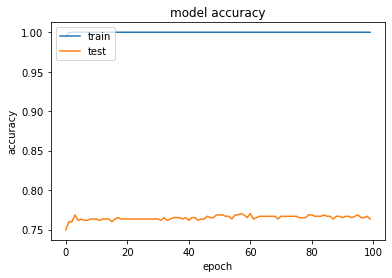

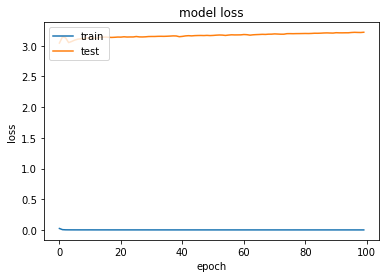

In [66]:
# summarize history for accuracy
plt.plot(history.history['accuracy'])
plt.plot(history.history['val_accuracy'])
plt.title('model accuracy')
plt.ylabel('accuracy')
plt.xlabel('epoch')
plt.legend(['train', 'test'], loc='upper left')
plt.show()
# summarize history for loss
plt.plot(history.history['loss'])
plt.plot(history.history['val_loss'])
plt.title('model loss')
plt.ylabel('loss')
plt.xlabel('epoch')
plt.legend(['train', 'test'], loc='upper left')
plt.show()

In [53]:
train_labels = np.argmax(train_encode_labels, axis=1)
train_predictions = model.predict_classes(train_encode)

Confusion matrix, without normalization
[[  65    0    0    0    0    0]
 [   0  250    0    0    0    0]
 [   0    0 1422    0    0    0]
 [   0    0    0  224    2    0]
 [   0    0    3    0  204    0]
 [   0    0    0    0    0  146]]
Normalized confusion matrix
[[1.      0.      0.      0.      0.      0.     ]
 [0.      1.      0.      0.      0.      0.     ]
 [0.      0.      1.      0.      0.      0.     ]
 [0.      0.      0.      0.99115 0.00885 0.     ]
 [0.      0.      0.01449 0.      0.98551 0.     ]
 [0.      0.      0.      0.      0.      1.     ]]


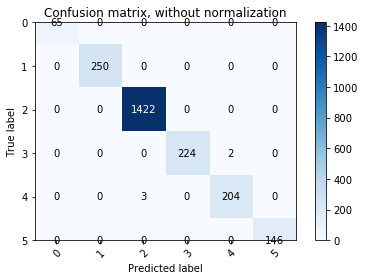

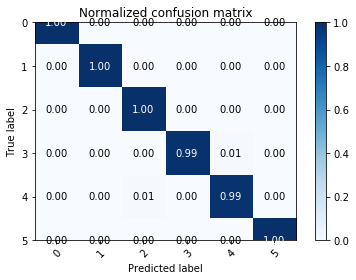

In [54]:
plot_confusion_matrix(train_labels, train_predictions,
                      title='Confusion matrix, without normalization')

plot_confusion_matrix(train_labels, train_predictions, normalize=True,
                      title='Normalized confusion matrix')

Confusion matrix, without normalization
[[  6   1   4   0   1   2]
 [  1  45  17   7   6   3]
 [  2  17 323   8   9   2]
 [  0   3  12  35   1   2]
 [  2   6   6   0  24   2]
 [  2   4  14   1   1  10]]
Normalized confusion matrix
[[0.42857 0.07143 0.28571 0.      0.07143 0.14286]
 [0.01266 0.56962 0.21519 0.08861 0.07595 0.03797]
 [0.00554 0.04709 0.89474 0.02216 0.02493 0.00554]
 [0.      0.0566  0.22642 0.66038 0.01887 0.03774]
 [0.05    0.15    0.15    0.      0.6     0.05   ]
 [0.0625  0.125   0.4375  0.03125 0.03125 0.3125 ]]


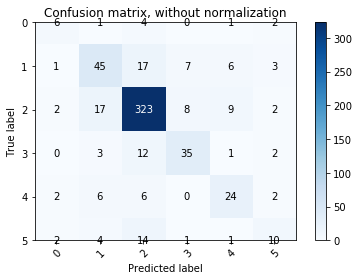

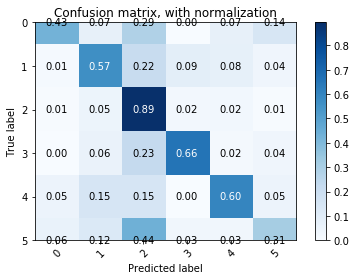

In [55]:
dev_labels = np.argmax(dev_encode_labels, axis=1)
dev_predictions = model.predict_classes(dev_encode)
plot_confusion_matrix(dev_labels, dev_predictions, normalize=False,
                      title='Confusion matrix, without normalization')
plot_confusion_matrix(dev_labels, dev_predictions, normalize=True,
                      title='Confusion matrix, with normalization')

In [67]:
clf = RandomForestClassifier(n_estimators=300)
clf.fit(train_encode, train['antigen.epitope'].values)

RandomForestClassifier(bootstrap=True, class_weight=None, criterion='gini',
                       max_depth=None, max_features='auto', max_leaf_nodes=None,
                       min_impurity_decrease=0.0, min_impurity_split=None,
                       min_samples_leaf=1, min_samples_split=2,
                       min_weight_fraction_leaf=0.0, n_estimators=300,
                       n_jobs=None, oob_score=False, random_state=None,
                       verbose=0, warm_start=False)

In [69]:
clf.score(dev_encode, dev['antigen.epitope'].values)

0.6044905008635578

In [52]:
# Adapted from https://scikit-learn.org/stable/auto_examples/model_selection/plot_confusion_matrix.html#sphx-glr-auto-examples-model-selection-plot-confusion-matrix-py: 

def plot_confusion_matrix(y_true, y_pred,
                          normalize=False,
                          title=None,
                          cmap=plt.cm.Blues):
    """
    This function prints and plots the confusion matrix.
    Normalization can be applied by setting `normalize=True`.
    """
    if not title:
        if normalize:
            title = 'Normalized confusion matrix'
        else:
            title = 'Confusion matrix, without normalization'

    # Compute confusion matrix
    cm = confusion_matrix(y_true, y_pred)
    # Only use the labels that appear in the data
    #classes = classes[unique_labels(y_true, y_pred)]
    if normalize:
        cm = cm.astype('float') / cm.sum(axis=1)[:, np.newaxis]
        print("Normalized confusion matrix")
    else:
        print('Confusion matrix, without normalization')

    print(cm)

    fig, ax = plt.subplots()
    im = ax.imshow(cm, interpolation='nearest', cmap=cmap)
    ax.figure.colorbar(im, ax=ax)
    # We want to show all ticks...
    ax.set(xticks=np.arange(cm.shape[1]),
           yticks=np.arange(cm.shape[0]),
           # ... and label them with the respective list entries
           #xticklabels=classes, yticklabels=classes,
           title=title,
           ylabel='True label',
           xlabel='Predicted label')

    # Rotate the tick labels and set their alignment.
    plt.setp(ax.get_xticklabels(), rotation=45, ha="right",
             rotation_mode="anchor")

    # Loop over data dimensions and create text annotations.
    fmt = '.2f' if normalize else 'd'
    thresh = cm.max() / 2.
    for i in range(cm.shape[0]):
        for j in range(cm.shape[1]):
            ax.text(j, i, format(cm[i, j], fmt),
                    ha="center", va="center",
                    color="white" if cm[i, j] > thresh else "black")
    fig.tight_layout()
    return ax


np.set_printoptions(precision=5)